In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter
from skimage.feature import local_binary_pattern
from sklearn.model_selection import KFold, cross_val_score
import joblib

SETTINGS

In [11]:
dataset_path = "CK+48"   # folder of your dataset


READ THE DATASET

In [16]:
imagePaths = list(paths.list_images('CK+48'))
image_size = 64                # standard input size
lbp_points = 8
lbp_radius = 1
emotion_labels = sorted(os.listdir(dataset_path))
imagePaths


['CK+48\\anger\\S010_004_00000017.png',
 'CK+48\\anger\\S010_004_00000018.png',
 'CK+48\\anger\\S010_004_00000019.png',
 'CK+48\\anger\\S011_004_00000019.png',
 'CK+48\\anger\\S011_004_00000020.png',
 'CK+48\\anger\\S011_004_00000021.png',
 'CK+48\\anger\\S014_003_00000028.png',
 'CK+48\\anger\\S014_003_00000029.png',
 'CK+48\\anger\\S014_003_00000030.png',
 'CK+48\\anger\\S022_005_00000030.png',
 'CK+48\\anger\\S022_005_00000031.png',
 'CK+48\\anger\\S022_005_00000032.png',
 'CK+48\\anger\\S026_003_00000013.png',
 'CK+48\\anger\\S026_003_00000014.png',
 'CK+48\\anger\\S026_003_00000015.png',
 'CK+48\\anger\\S028_001_00000022.png',
 'CK+48\\anger\\S028_001_00000023.png',
 'CK+48\\anger\\S028_001_00000024.png',
 'CK+48\\anger\\S029_001_00000017.png',
 'CK+48\\anger\\S029_001_00000018.png',
 'CK+48\\anger\\S029_001_00000019.png',
 'CK+48\\anger\\S032_003_00000015.png',
 'CK+48\\anger\\S032_003_00000016.png',
 'CK+48\\anger\\S032_003_00000017.png',
 'CK+48\\anger\\S034_003_00000025.png',


SHOW SAMPLE OF DATASET

In [17]:
print("\nDataset distribution:")
print(Counter(emotion_labels))


Dataset distribution:
Counter({'anger': 1, 'contempt': 1, 'disgust': 1, 'fear': 1, 'happy': 1, 'sadness': 1, 'surprise': 1})


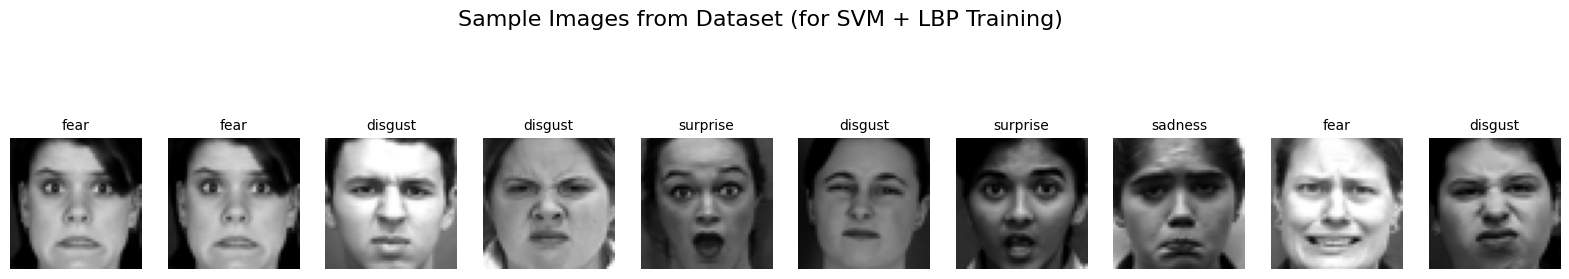

In [5]:
np.random.shuffle(imagePaths)
fig = plt.figure(figsize=(20, 4))

for i in range(10):
    # Load and prepare image
    img_path = imagePaths[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB for matplotlib

    # Get label (the folder name)
    label = img_path.split(os.path.sep)[-2]

    # Plot each image
    ax = fig.add_subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label, fontsize=10)

plt.suptitle("Sample Images from Dataset (for SVM + LBP Training)", fontsize=16)
plt.show()

Show the LBP-Transformed Images

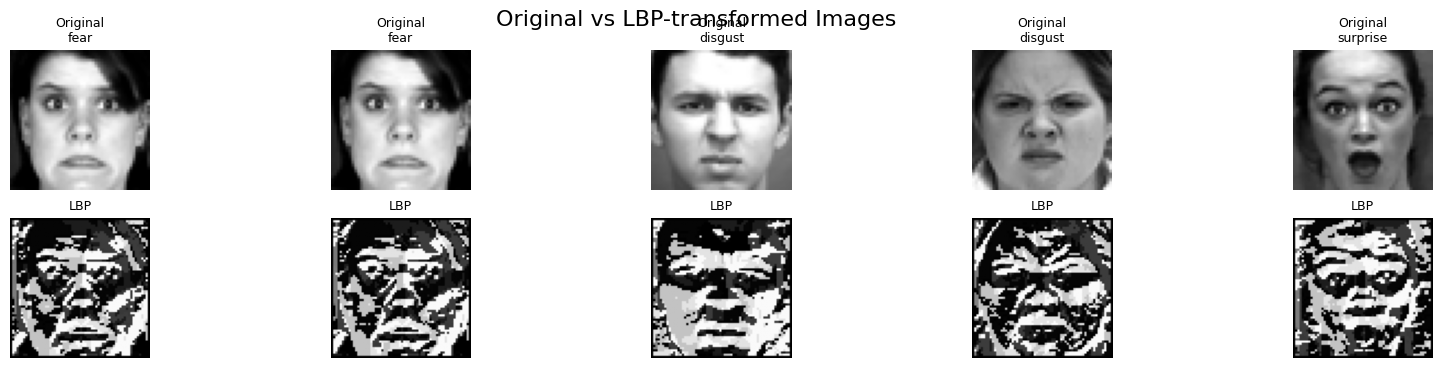

In [6]:
from skimage.feature import local_binary_pattern

def lbp_features(gray, numPoints=8, radius=1):
    lbp = local_binary_pattern(gray, numPoints, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, numPoints + 3),
                             range=(0, numPoints + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist


def lbp_image(gray, numPoints=8, radius=1):
    lbp_image = np.zeros_like(gray)
    for i in range(radius, gray.shape[0]-radius):
        for j in range(radius, gray.shape[1]-radius):
            center = gray[i,j]
            binary = 0
            for k in range(numPoints):
                theta = 2*np.pi*k/numPoints
                x = int(i + radius*np.sin(theta))
                y = int(j + radius*np.cos(theta))
                binary |= (gray[x,y] > center) << k
            lbp_image[i,j] = binary
    return lbp_image

# Show original + LBP side by side
fig = plt.figure(figsize=(20, 4))
for i in range(5):
    img_path = imagePaths[i]
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    lbp = lbp_image(cv2.resize(gray, (64, 64)))

    label = img_path.split(os.path.sep)[-2]

    # Original
    ax = fig.add_subplot(2, 5, i + 1)
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.title(f"Original\n{label}", fontsize=9)

    # LBP
    ax = fig.add_subplot(2, 5, i + 6)
    plt.imshow(lbp, cmap='gray')
    plt.axis('off')
    plt.title("LBP", fontsize=9)

plt.suptitle("Original vs LBP-transformed Images", fontsize=16)
plt.show()


LBP parameters

In [7]:
radius = 1        # pixel radius
n_points = 8 * radius  # number of circularly symmetric neighbour set points
METHOD = 'uniform'  # 'uniform' gives more stable features


FEATURE EXTRACTION

In [12]:
features = []
labels = []

print("[INFO] Extracting LBP features from dataset...")
for emotion in emotion_labels:
    folder = os.path.join(dataset_path, emotion)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, (64, 64))

        # Compute LBP
        lbp = local_binary_pattern(img, n_points, radius, METHOD)

        # Compute histogram of LBP values
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))

        # Normalize histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)

        features.append(hist)
        labels.append(emotion)

features = np.array(features)
labels = np.array(labels)

print(f"[INFO] Total images processed: {len(features)}")
print(f"[INFO] Each feature vector has {features.shape[1]} dimensions")


[INFO] Extracting LBP features from dataset...
[INFO] Total images processed: 981
[INFO] Each feature vector has 10 dimensions


TRAIN SVM MODEL

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"[INFO] Number of images used for training: {len(X_train)}")
print(f"[INFO] Number of images used for testing:  {len(X_test)}")


[INFO] Number of images used for training: 784
[INFO] Number of images used for testing:  197


In [14]:
print("\n[INFO] Training SVM model...")
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True)
svm_clf.fit(X_train, y_train)


[INFO] Training SVM model...


,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


EVALUATE MODEL

In [15]:
# EVALUATE ON TRAINING SET
print("========== TRAINING SET PERFORMANCE ==========")
y_train_pred = svm_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n[TRAIN] Classification Report:\n", classification_report(y_train, y_train_pred, zero_division=0))
print("[TRAIN] Accuracy: {:.2f}%".format(train_accuracy * 100))
print("[TRAIN] Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

# EVALUATE ON TEST SET
print("\n========== TESTING SET PERFORMANCE ==========")
y_test_pred = svm_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n[TEST] Classification Report:\n", classification_report(y_test, y_test_pred, zero_division=0))
print("[TEST] Accuracy: {:.2f}%".format(test_accuracy * 100))
print("[TEST] Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


========== TRAINING SET PERFORMANCE ==========

[TRAIN] Classification Report:
               precision    recall  f1-score   support

       anger       0.34      0.32      0.33       108
    contempt       0.14      0.72      0.24        43
     disgust       0.44      0.50      0.47       142
        fear       0.12      0.27      0.17        60
       happy       0.43      0.26      0.32       165
     sadness       0.07      0.01      0.02        67
    surprise       0.53      0.15      0.23       199

    accuracy                           0.29       784
   macro avg       0.30      0.32      0.25       784
weighted avg       0.37      0.29      0.28       784

[TRAIN] Accuracy: 28.83%
[TRAIN] Confusion Matrix:
 [[35 34 19 10  7  0  3]
 [ 3 31  4  5  0  0  0]
 [19 24 71  6 16  1  5]
 [ 2 20  8 16  7  3  4]
 [17 23 26 38 43  6 12]
 [10 30  9 12  3  1  2]
 [18 57 25 43 24  3 29]]

========== TESTING SET PERFORMANCE ==========

[TEST] Classification Report:
               precision

CROSS VALIDATION

3-FOLD

In [35]:
cv = KFold(n_splits=3, random_state=1, shuffle=True)
scores = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN Accuracy:', str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation:', str(np.std(scores)*100)[:5] + '%')


SVM MEAN Accuracy: 22.94%
Standard deviation: 0.206%


5-FOLD

In [36]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN Accuracy:', str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation:', str(np.std(scores)*100)[:5] + '%')

SVM MEAN Accuracy: 22.78%
Standard deviation: 0.649%


10-FOLD

In [37]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(svm_clf, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN Accuracy:', str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation:', str(np.std(scores)*100)[:5] + '%')

SVM MEAN Accuracy: 22.87%
Standard deviation: 1.304%


Save Model

In [21]:
print("\nClasses in model:", np.unique(y_train))


Classes in model: ['anger' 'contempt' 'disgust' 'fear' 'happy' 'sad' 'surprise']


In [38]:
joblib.dump(svm_clf, "SVM-LBP_model_FER2013.pkl")
np.save("LBP_emotion_labels_FER2013.npy", np.unique(labels))
print("\n[INFO] Model saved as svm_lbp_emotion_model.pkl")



[INFO] Model saved as svm_lbp_emotion_model.pkl
